In [1]:
import pandas as pd
import scipy as sci
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
from scipy.signal import butter, lfilter
import datetime
%matplotlib inline

In [2]:
TP_L = 0
IF_L = 1
IF_R = 2
TP_R = 3
BASELINE = 4



In [42]:
eegF1_df = pd.read_json('file:eegData_F1.json')
eegF2_df = pd.read_json('file:eegData_F2.json')
eegF3_df = pd.read_json('file:eegData_F3.json')
eegM1_df = pd.read_json('file:eegData_M1.json')
eegM2_df = pd.read_json('file:eegData_M2.json')
eegM3_df = pd.read_json('file:eegData_M3.json')
eegM4_df = pd.read_json('file:eegData_M4.json')
eegM5_df = pd.read_json('file:eegData_M5.json')

eventF1_df = pd.read_json('file:Event_F1.json')
eventF2_df = pd.read_json('file:Event_F2.json')
eventF3_df = pd.read_json('file:Event_F3.json')
eventM1_df = pd.read_json('file:Event_M1.json')
eventM2_df = pd.read_json('file:Event_M2.json')
eventM3_df = pd.read_json('file:Event_M3.json')
eventM4_df = pd.read_json('file:Event_M4.json')
eventM5_df = pd.read_json('file:Event_M5.json')

accelF1_df = pd.read_json('file:accelerometerJson_F1.json')
accelM1_df = pd.read_json('file:accelerometerJson_M1.json')
fs = 256
eventM1_df = eventM1_df[['value', 'timestamp']]
participants_eeg = [eegF2_df, eegF3_df,eegM5_df]
participants_event = [eventF2_df,eventF3_df,eventM5_df]

In [43]:
for i in participants_event:
    print(i)

    picIndex                  timestamp
0          0 2019-07-30 02:07:48.628125
1          0 2019-07-30 02:07:53.034375
2          4 2019-07-30 02:07:57.487500
3          4 2019-07-30 02:08:01.893750
4          0 2019-07-30 02:08:06.346875
5          0 2019-07-30 02:08:10.753125
6          7 2019-07-30 02:08:15.159375
7          7 2019-07-30 02:08:19.612500
8          1 2019-07-30 02:08:24.018750
9          1 2019-07-30 02:08:28.471875
10        16 2019-07-30 02:08:32.878125
11        16 2019-07-30 02:08:37.284375
12         1 2019-07-30 02:08:41.737500
13         1 2019-07-30 02:08:46.143750
14         4 2019-07-30 02:08:50.596875
15         4 2019-07-30 02:08:55.003125
16         5 2019-07-30 02:08:59.409375
17         5 2019-07-30 02:09:03.862500
18         2 2019-07-30 02:09:08.268750
19         2 2019-07-30 02:09:12.721875
20        16 2019-07-30 02:09:17.128125
21        16 2019-07-30 02:09:21.534375
22         0 2019-07-30 02:09:25.987500
23         0 2019-07-30 02:09:30.393750


In [44]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def clean_data(data, fs):
#    print(data.shape)
#    print(np.isnan(data).any())
    mean = np.mean(data)
#    print(data.shape,'Mean: ' + str(mean))
#    print(type(mean))
#    print(mean)
    data = data - mean
#    print(data.shape)
#    print(np.isnan(data).any())
#    print(data)
    data = butter_bandpass_filter(data, .5, 15, fs)
#    print(data)
#    print(data.shape)
#    print(np.isnan(data).any())
    return data

def discard_first_trial(eventlist):
    eventlist = np.delete(eventlist,0,1)
    return eventlist


In [45]:
def datetime_to_float(d):
    epoch = datetime.datetime.utcfromtimestamp(0)
    total_seconds =  (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds

def compute_EEG_indices(event_timestamps, fs):
    indices = np.array([int(i * fs) for i in event_timestamps]).astype(int)
    return indices

def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

In [46]:
def process_eeg_dataframe(df):
    df_raw_time_vector = df[df['electrode'] == 0]['timestamp'].to_numpy()
    time_spacing = []
    
    for i in np.arange(1,len(df_raw_time_vector)):
        time_spacing.append(df_raw_time_vector[i]-df_raw_time_vector[i-1])

        if(i>1):
            if(not time_spacing[i-1] == time_spacing[i-2]):
                print(time_spacing[i-1],time_spacing[i-2])

    dt_stamp = time_spacing[0]
    dt = dt_stamp / np.timedelta64(1, 's')
    
    T = df_raw_time_vector[-1] - df_raw_time_vector[0] + dt_stamp
    T = T / np.timedelta64(1, 's')

    time_vector = np.arange(0,T,dt/12)
    
    channel_list = []
    eeg_channels = []
    for channel in np.arange(5):
        channel_list.append(df[df['electrode'] == channel])
        eeg_temp = channel_list[channel]['samples'].tolist()
        eeg = []
        for a in eeg_temp:
            for b in a:
                eeg.append(b)
        eeg_channels.append(clean_data(np.array(eeg),fs))
#        print('shape of channel ',channel,': ',eeg_channels[channel].shape)
    eeg_channels = np.array(eeg_channels).squeeze()
    return time_vector,eeg_channels,T

In [47]:
def process_event_dataframe(df,start_time):
    data = df.to_numpy()
    for i in np.arange(len(data)):
        data[i,1] = (datetime_to_float(df["timestamp"][i]) - start_time)
    return data.T

def first_timestamp(df):
    timestamp = df['timestamp'][0]
    return timestamp

In [48]:
def grab_epoch(data, index, fs, len_pre, len_post):
    epoch = np.array([i for i in data[(index+int(len_pre*fs) if index+int(len_pre*fs) >= 0 else 0):index+(len_post*fs)]])
    return epoch

def get_windows(data, indices, fs, len_pre, len_post):
    epoch_list = []
    for index in indices:
        epoch = []
        if index+int(len_pre*fs) < 0 or index+int(len_post*fs) >= len(data): 
            continue
        start = index+int(len_pre*fs) 
        end = index+int(len_post*fs)
        baseline = np.mean(data[start:index])
        for value in data[start:end]:
            epoch.append(value - baseline)
        epoch_list.append(epoch)
    return np.array(epoch_list)

In [49]:
time_vector_list = []
eeg_list = []
length_list = []
event_list = []

for i in np.arange(len(participants_eeg)):
#    print(i)
    time_vector,eeg,T = process_eeg_dataframe(participants_eeg[i])
    time_vector_list.append(time_vector)
    eeg_list.append(eeg)
    length_list.append(T)
    event = process_event_dataframe(participants_event[i],datetime_to_float(first_timestamp(participants_eeg[i])))
    event[1] = compute_EEG_indices(event[1], fs)
    event = discard_first_trial(event)
    event_list.append(event)
    
    

#M2_time_vector,M2_eeg,M2_T = process_eeg_dataframe(eegM2_df)
#M3_time_vector,M3_eeg,M3_T = process_eeg_dataframe(eegM3_df)


In [50]:
#print(M2_time_vector.shape,M2_eeg.shape)
print(length_list)
#participants_eeg = [eegF2_df, eegF3_df, eegM1_df, eegM2_df, eegM3_df, eegM4_df, eegM5_df]

[168.796875, 168.796875, 168.796875]


In [51]:
#eventM2_df["timestamp"][0]

In [52]:
M1_offset = datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))
M2_offset = datetime_to_float(eventM2_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM2_df))
M3_offset = datetime_to_float(eventM3_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM3_df))
M4_offset = datetime_to_float(eventM4_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM4_df))
M5_offset = datetime_to_float(eventM5_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM5_df))
F1_offset = datetime_to_float(eventF1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF1_df))
F2_offset = datetime_to_float(eventF2_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF2_df))
F3_offset = datetime_to_float(eventF3_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF3_df))

print('M1 offset: ' + str(M1_offset))
print('M2 offset: ' + str(M2_offset))
print('M3 offset: ' + str(M3_offset))
print('M4 offset: ' + str(M4_offset))
print('M5 offset: ' + str(M5_offset))
print('F1 offset: ' + str(F1_offset))
print('F2 offset: ' + str(F2_offset))
print('F3 offset: ' + str(F3_offset))

print((M3_offset + M4_offset)/2)

# note: fix indices for M3 and M4

M1 offset: 11.270625114440918
M2 offset: 11.25
M3 offset: -3165.8001251220703
M4 offset: 3174.6126248836517
M5 offset: 4.40625
F1 offset: 611.2706251144409
F2 offset: 4.40625
F3 offset: 4.453125
4.4062498807907104


In [53]:
datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))

11.270625114440918

In [54]:
datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))

11.270625114440918

In [55]:
datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))

11.270625114440918

In [56]:
-3165.8001251220703 - 4.40625

-3170.2063751220703

In [57]:
#eventM2 = process_event_dataframe(eventM2_df,datetime_to_float(first_timestamp(eegM2_df)))
#print(eventM2)
#eventM2[1] = compute_EEG_indices(eventM2[1], fs)
#print(eventM2)
#eventM2 = discard_first_trial(eventM2)
#print(eventM2)

In [58]:
#M2_eeg[0]

In [59]:
#M2_T


In [60]:
#M2_time_vector

In [61]:
#first_stimulus = (first_timestamp(eventM1_df) - first_timestamp(eegM1_df))/np.timedelta64(1, 's')

In [62]:
#first_stimulus

In [63]:
#first_stimulus_index = find_nearest(M2_time_vector, first_stimulus)

In [64]:
#first_stimulus - M2_time_vector[2885]

In [65]:
#FIR_theta = signal.firwin(751, cutoff=(4,10), fs=fs, pass_zero=False)
#theta_osc = np.empty(M2_eeg.shape)
#theta_osc[0] = np.convolve(M2_eeg[0], FIR_theta, mode='same')
#theta_osc[1] = np.convolve(M2_eeg[1], FIR_theta, mode='same')
#theta_osc[2] = np.convolve(M2_eeg[2], FIR_theta, mode='same')
#theta_osc[3] = np.convolve(M2_eeg[3], FIR_theta, mode='same')
#theta_osc[4] = np.convolve(M2_eeg[4], FIR_theta, mode='same')

#t_vector = np.arange(0,len(M2_eeg[0])/fs,1/fs)

#plt.figure(figsize=(15,12))
# plot the signal and the filtered signal
#plt.plot(t_vector, M2_eeg[0], '-', label = "origional")
#plt.plot(t_vector, theta_osc[0], '-', label = "theta")
#plt.xlim([M2_time_vector[2885]-1,M2_time_vector[2885]+2])
#plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)');
#plt.legend()


In [66]:
len_pre = -1
len_post = 2

In [77]:
cat_index = []
snake_index = []

for i in np.arange(len(eeg_list)):
    cat_index.append([])
    snake_index.append([])            

epochs_cat = [[],[],[],[],[]]
epochs_snake = [[],[],[],[],[]]


for participant in np.arange(len(eeg_list)):
    for i in np.arange(len(event_list[participant][0])):
#        print(participant,i)
        if(event_list[participant][0][i] < 12):
            cat_index[participant].append(event_list[participant][1][i])
        else:
            snake_index[participant].append(event_list[participant][1][i])



for participant in np.arange(len(eeg_list)):
    for channel in np.arange(5):
        cat_windows = np.array(get_windows(eeg_list[participant][channel], cat_index[participant], fs, len_pre, len_post))
        snake_windows = np.array(get_windows(eeg_list[participant][channel], snake_index[participant], fs, len_pre, len_post))
        for epoch in cat_windows:
            epochs_cat[channel].append(epoch)
        for epoch in snake_windows:
            epochs_snake[channel].append(epoch)    
        
epochs_cat = np.array(epochs_cat)

epochs_snake = np.array(epochs_snake)


In [78]:
#participant = 5
#channel = 1
#get_windows(eeg_list[participant][channel], cat_index[participant], fs, len_pre, len_post)

In [79]:
#cat_index[participant]


    

In [83]:
#cat_index
#snake_index
#epochs_cat
#epochs_snake
print(np.array(epochs_cat[0]).shape)
print(np.array(epochs_snake[0]).shape)


(82, 768)
(26, 768)


In [85]:

cat_average = []
snake_average = []
for channel in np.arange(5):
#    print(np.array(epochs_cat[channel]).shape)
    cat_average.append(np.mean(epochs_cat[channel], axis=0))
    snake_average.append(np.mean(epochs_snake[channel], axis=0))

cat_average= np.array(cat_average)
snake_average= np.array(snake_average)

epoch_time = np.arange(len_pre, len_post, 1/fs)

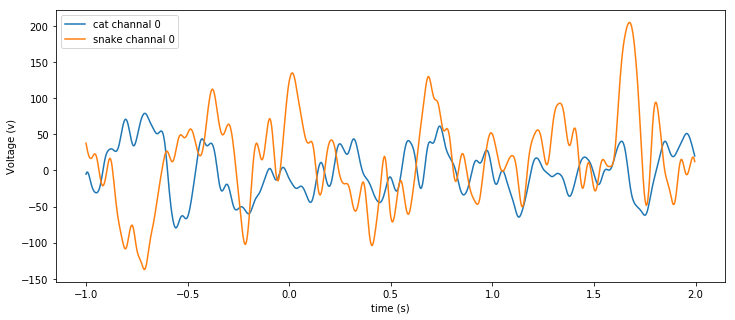

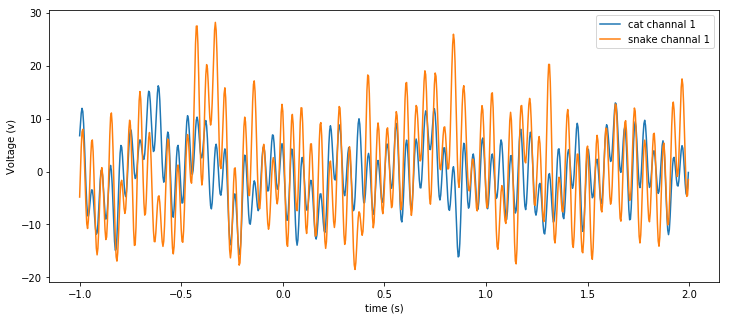

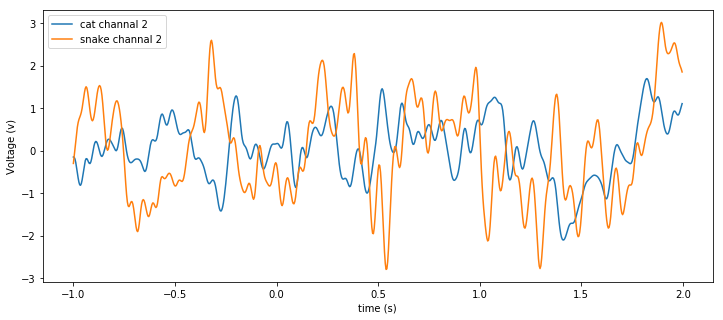

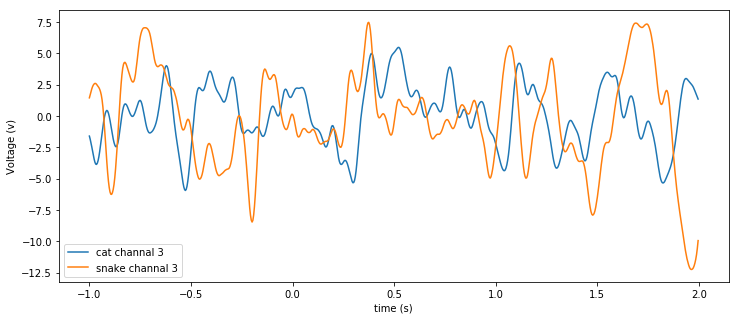

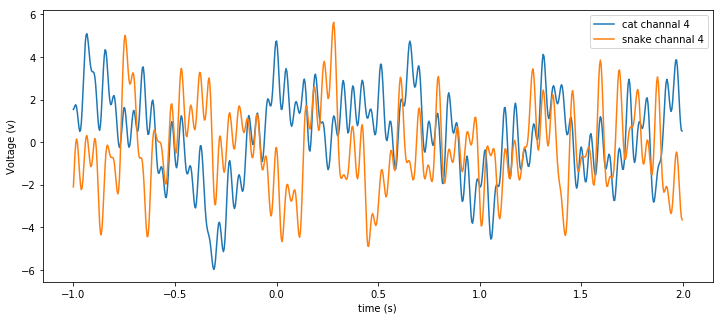

In [91]:
for i in range(0,5):
    # plot STA
    plt.figure(figsize=(12,5))
    plt.plot(epoch_time, cat_average[i], '-', label = "cat channal " + str(i))
    plt.plot(epoch_time, snake_average[i], '-', label = "snake channal " + str(i))
    plt.xlabel('time (s)'); plt.ylabel('Voltage (v)');
    plt.legend()


In [ ]:
# plot all the epochs and average
plt.figure(figsize=(12,5))
plt.plot(epoch_time, epochs[0].T, '-k', alpha=0.01)
plt.plot(epoch_time, trial_average[0], label='Average Response')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.ylim([-20,20])
plt.legend()

In [ ]:
eventM2

In [ ]:
catIndex = []
snakeIndex = []
for i in range(0, len(eventM2[0])):
    if(eventM2[0][i] < 12):
        catIndex.append(eventM2[1][i])
    else:
        snakeIndex.append(eventM2[1][i])
        
print(catIndex)
print(snakeIndex)

In [ ]:
epochs_cats = []
epochs_cats.append(get_windows(M2_eeg[0], catIndex, fs, len_pre, len_post))
epochs_cats.append(get_windows(M2_eeg[1], catIndex, fs, len_pre, len_post))
epochs_cats.append(get_windows(M2_eeg[2], catIndex, fs, len_pre, len_post))
epochs_cats.append(get_windows(M2_eeg[3], catIndex, fs, len_pre, len_post))
epochs_cats.append(get_windows(M2_eeg[4], catIndex, fs, len_pre, len_post))
epochs_cats = np.array(epochs_cats)

print(epochs_cats.shape)

epochs_snakes = []
epochs_snakes.append(get_windows(M2_eeg[0], snakeIndex, fs, len_pre, len_post))
epochs_snakes.append(get_windows(M2_eeg[1], snakeIndex, fs, len_pre, len_post))
epochs_snakes.append(get_windows(M2_eeg[2], snakeIndex, fs, len_pre, len_post))
epochs_snakes.append(get_windows(M2_eeg[3], snakeIndex, fs, len_pre, len_post))
epochs_snakes.append(get_windows(M2_eeg[4], snakeIndex, fs, len_pre, len_post))
epochs_snakes = np.array(epochs_snakes)

print(epochs_snakes.shape)

In [ ]:
cat_average = list()
for i in np.arange(epochs_cats.shape[0]):
    cat_average.append(np.mean(epochs_cats[i], axis=0))
cat_average= np.array(cat_average)

snake_average = list()
for i in np.arange(epochs_snakes.shape[0]):
    snake_average.append(np.mean(epochs_snakes[i], axis=0))
snake_average= np.array(snake_average)

electrode = 0


In [ ]:
print(epoch_time.shape)
print(epochs_cats.shape)
print(cat_average.shape)

In [ ]:
# plot STA
plt.figure(figsize=(12,5))
plt.plot(epoch_time, cat_average[electrode], '-', label="cat")
plt.plot(epoch_time, snake_average[electrode], '-', label="snake")

#plt.plot(epoch_time, cat_average[1], '-')
#plt.plot(epoch_time, cat_average[2], '-')
#plt.plot(epoch_time, cat_average[3], '-')
#plt.plot(epoch_time, cat_average[4], '-')

plt.xlabel('time (s)'); plt.ylabel('Voltage (v)');
plt.legend()

In [ ]:
plt.figure(figsize=(12,5))
for i in np.arange(epochs_cats.shape[1]):
    plt.plot(epoch_time, epochs_cats[1][i], '-', label="cat "+ str(i))

#plt.plot(epoch_time, cat_average[1], '-')
#plt.plot(epoch_time, cat_average[2], '-')
#plt.plot(epoch_time, cat_average[3], '-')
#plt.plot(epoch_time, cat_average[4], '-')

plt.xlabel('time (s)'); plt.ylabel('Voltage (v)');
plt.legend()